# Import Libraries

In [42]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from choices import param_dict 
from utilities import deets

# Load data

In [98]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] )


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False).reset_index(drop=True)
y = df['class'].reset_index(drop=True)
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________


AttributeError: 'Index' object has no attribute 'reset_index'

## Loss Function

In [96]:
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
le = LabelEncoder()
X = x.copy()
y_label = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.20, random_state=42)

classes =[]
labeles=np.unique(y_label)
for v in labeles:
    classes.append('Class '+ str(v))
print(classes)

['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']


In [75]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score , recall_score , confusion_matrix , plot_confusion_matrix
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('Prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles)
#plot_confusion_matrix(cnf_matrix, labels=classes,normalize=True,  title='Confusion matrix')


Prediction accuracy 0.9279688513951979  recall  0.7581120165170178


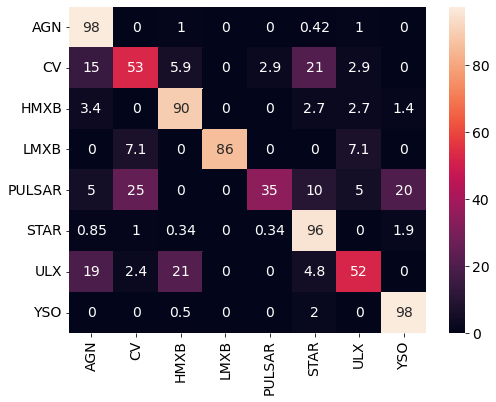

In [76]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles , normalize='true')
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(8,6))
l_name = le.inverse_transform(labeles)
sns.heatmap(cnf_matrix*100 , annot=True , xticklabels=l_name , yticklabels=l_name , ax=ax)
plt.show()

In [93]:
from OneVsRestLightGBMWithCustomizedLoss import *
from FocalLoss import FocalLoss #get the FocalLoss implementation from Halford's blog

# Instantiate Focal loss
loss = FocalLoss(alpha=0.75, gamma=1.0)

# Not using early stopping
clf = OneVsRestLightGBMWithCustomizedLoss(loss=loss)
#clf.fit(X_train, y_train)

# Using early stopping
fit_params = {
    'eval_set': [(X_test, y_test)] , 
    'verbose':2 ,
    }
clf.fit(X_train, y_train, **fit_params)

y_test_pred = clf.predict(X_test)
pred_accuracy_score = accuracy_score(y_test, y_test_pred)
pred_recall_score = recall_score(y_test, y_test_pred, average='macro')
print('prediction accuracy', pred_accuracy_score,' recall ', pred_recall_score)


/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] J103154.8+574521 is set=, J103154.8+574521= will be ignored. Current value: J103154.8+574521=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of data points in the train set: 6162, number of used features: 41
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ig

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] J100231.9+023507 is set=, J100231.9+023507= will be ignored. Current value: J100231.9+023507=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] J064104.2+092452 is set=, J064104.2+092452= will be ignored. Current value: J064104.2+092452=
[Lig

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] J103154.8+574521 is set=, J103154.8+574521= will be ignored. Current value: J103154.8+574521=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will 

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] J205357.5+322314 is set=, J205357.5+322314= will be ignored. Current value: J205357.5+322314=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] 2CXO is set=, 2CXO= will be ignored. Current value: 2CXO=
[LightGBM] [Warning] J100231.9+023507 is set=, J100231.9+023507= will be ignored. Current value: J100231.9+023507=
[LightGBM] [Warning] ... is set=, ...= will be ignored. Current value: ...=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[LightGBM] [Warning] NaN is set=, NaN= will be ignored. Current value: NaN=
[Lig

KeyboardInterrupt: 

Trained a tree with leaves = 31 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[20]	fit's focal_loss: 0.00722309	val's focal_loss: 0.0195123
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree

/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kumaran/.local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: 9.997766
[LightGBM] [Warning] Unknown parameter: 2.103703
[LightGBM] [Warning] Unknown parameter: gal_l2
[LightGBM] [Warning] Unknown parameter: 9.996500
[LightGBM] [Warning] Unknown parameter: 8.75
[LightGBM] [Warning] Unknown parameter: 4.997464
[LightGBM] [Warning] Unknown parameter: 5.983391
[LightGBM] [Warning] Unknown parameter: 6.577977
[LightGBM] [Warning] Unknown parameter: 5.829992
[LightGBM] [Warning] Unknown parameter: var_inter_sigma_b
[LightGBM] [Warning] Unknown parameter: var_inter_index_b
[LightGBM] [Warning] Unknown parameter: var_intra_prob_b
[LightGBM] [Warning] Unknown parameter: 8.828057
[LightGBM] [Warning] Unknown parameter: kp_intra_prob_b
[LightGBM] [Warning] Unknown parameter: 0.001210
[LightGBM] [Warning] Unknown parameter: 3.084993e-08
[LightGBM] [Warning] Unknown parameter: 2.0
[LightGBM] [Warning] Unknown parameter: 5.841755
[LightGBM] [Warning] Unknown parameter: 10.00
[LightGBM] [Warning] Unknown parameter: 3.2194

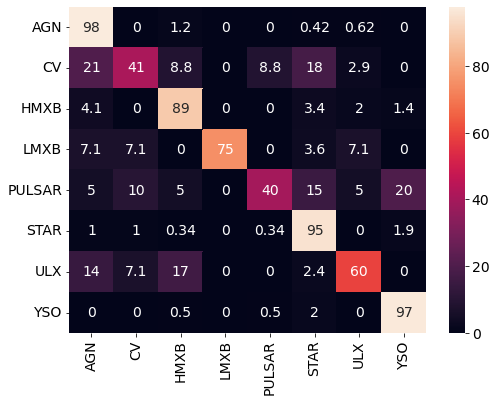

In [87]:
cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labeles , normalize='true')
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(8,6))
l_name = le.inverse_transform(labeles)
sns.heatmap(cnf_matrix*100 , annot=True , xticklabels=l_name , yticklabels=l_name , ax=ax)
plt.show()